# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.88'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne--Spectrum--006--Spec.Data 1.txt',
 '02 Ne--Spectrum--007--Spec.Data 1.txt',
 '03 Ne--Spectrum--008--Spec.Data 1.txt',
 '07 Ne--Spectrum--012--Spec.Data 1.txt',
 '11 Ne--Spectrum--019--Spec.Data 1.txt',
 '15 Ne--Spectrum--023--Spec.Data 1.txt',
 '16 Ne--Spectrum--024--Spec.Data 1.txt',
 '19 Ne--Spectrum--033--Spec.Data 1.txt',
 '32 Ne--Spectrum--051--Spec.Data 1.txt',
 '36 Ne--Spectrum--058--Spec.Data 1.txt',
 '40 Ne--Spectrum--063--Spec.Data 1.txt',
 '44 Ne--Spectrum--067--Spec.Data 1.txt',
 '48 Ne--Spectrum--077--Spec.Data 1.txt',
 '51 Ne--Spectrum--080--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
3           391.536362     2500.0                543.36513
15          818.699523     5000.0                556.27662
23         1117.086987     5000.0                565.66588
30         1310.480205     5000.0                571.92248
33         1398.915133     5000.0                574.82985

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Line_1_int  Line_2_int  \
0  330.477634  1117.086987  1447.564622      5000.0      7000.0   

   Entered Pos Line 1  Entered Pos Line 2  
0                1117                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--Spectrum--006--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.72474   4202.333496  1447.663174       53096.0  3491.366827   

     Peak2_prom  
0  52385.033331

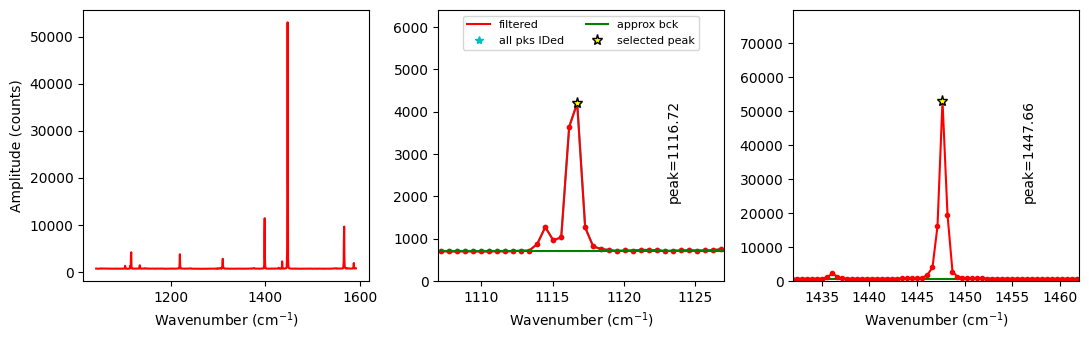

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  \
0  Ne--Spectrum--006--Spec.Data 1.txt         0.000033    0.000033   

   pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  \
0    1447.688593   51579.919628   0.401305      None   0.002034   

   Peak2_Prop_Lor  pk1_peak_cent  ...  Peak1_Prop_Lor     deltaNe  Ne_Corr  \
0        0.402197     1116.48885  ...        0.243181  331.199743  0.99782   

   Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  \
0     0.997781     0.997858    131.109098     13.851992         144.96109   

   error_pk1_amplitude  error_pk2_amplitude  
0           225.087959           356.212052  

[1 rows x 24 columns]

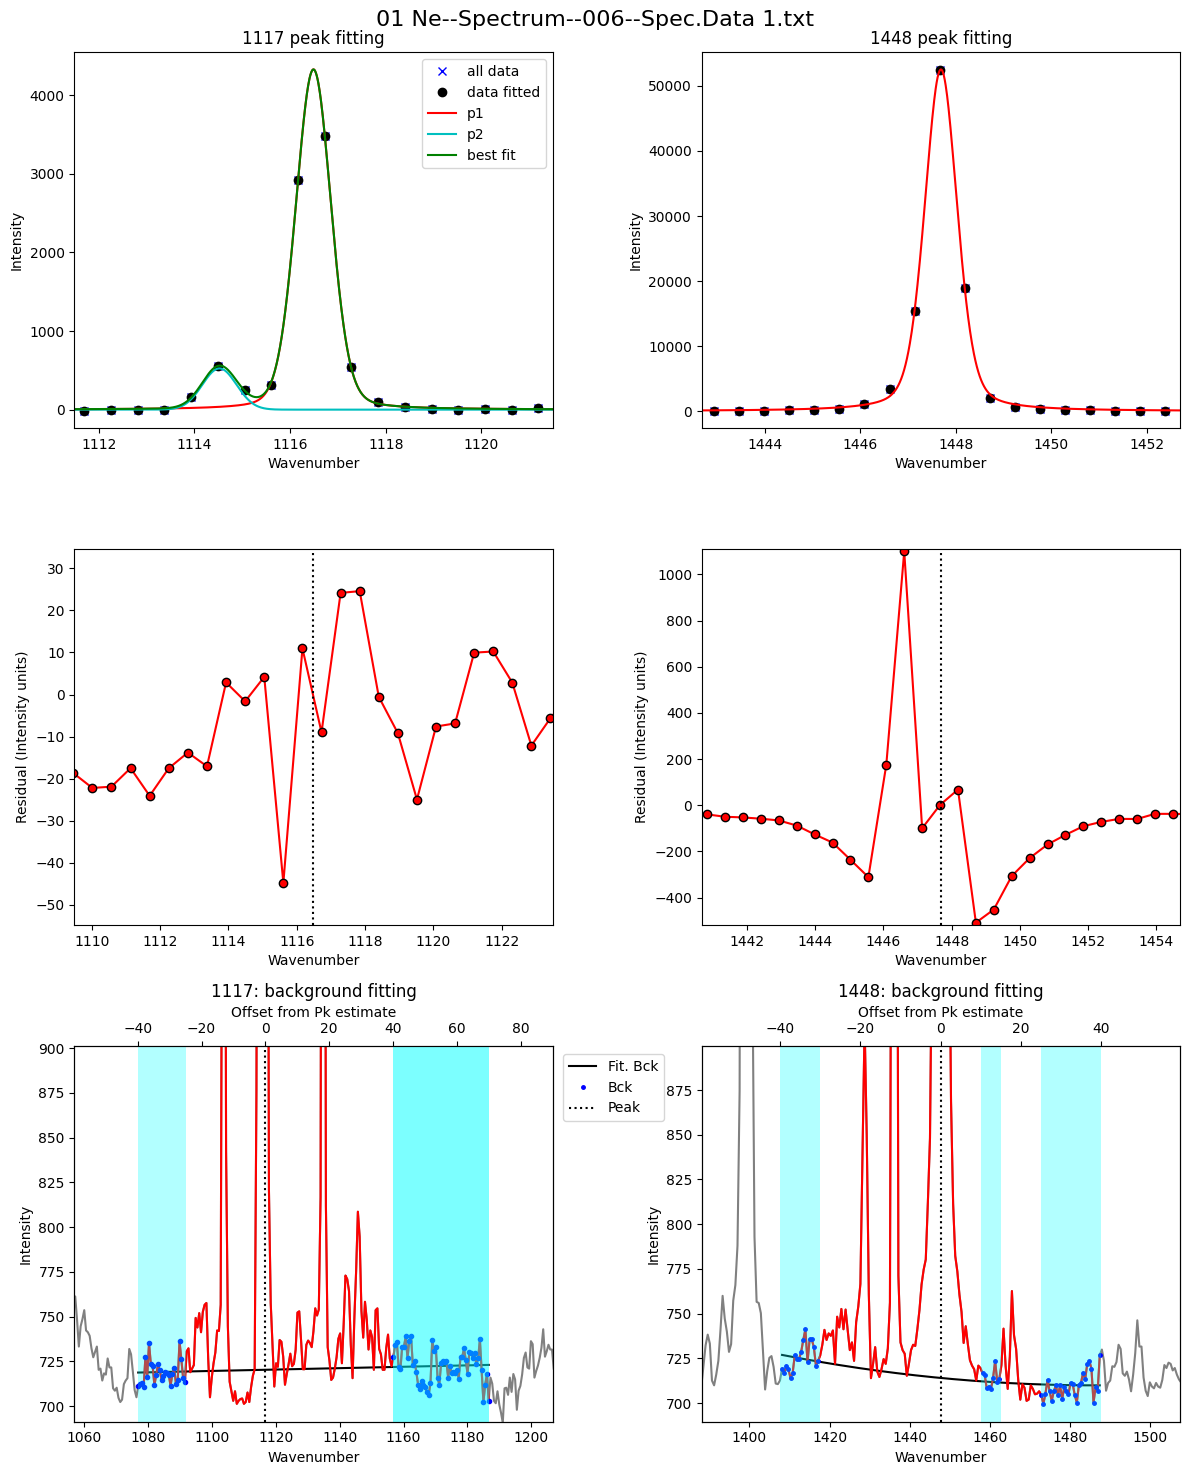

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/14 [00:00<?, ?it/s]

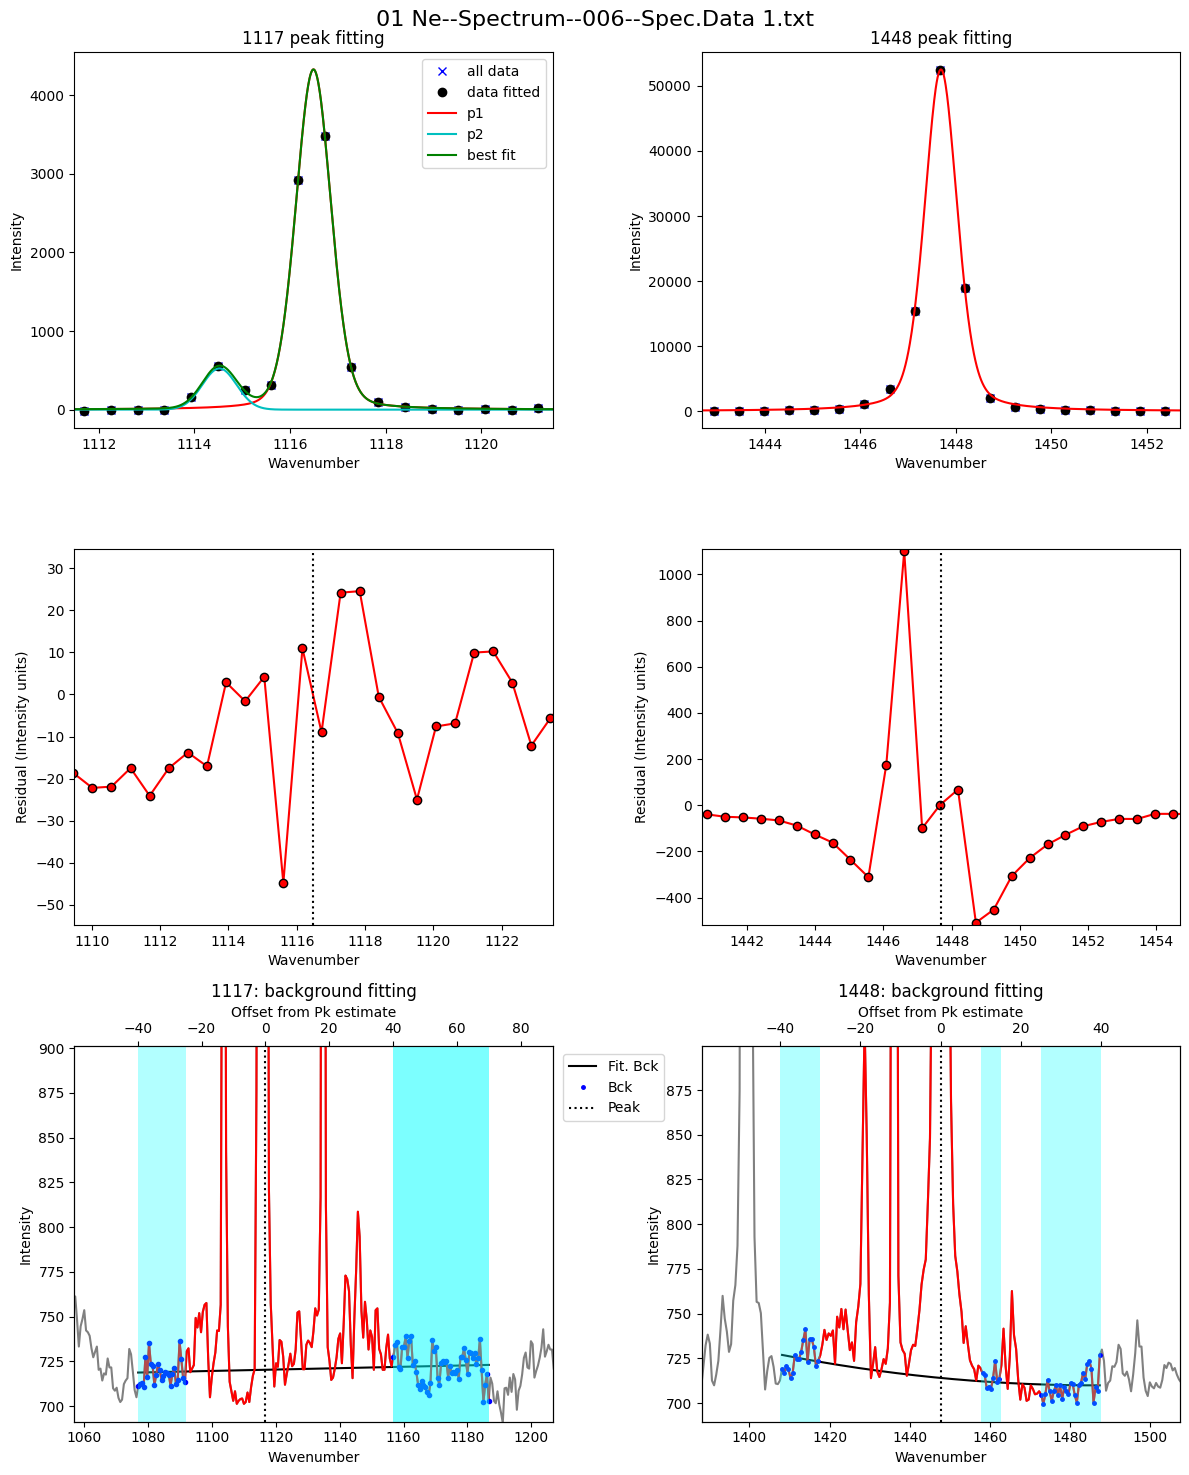

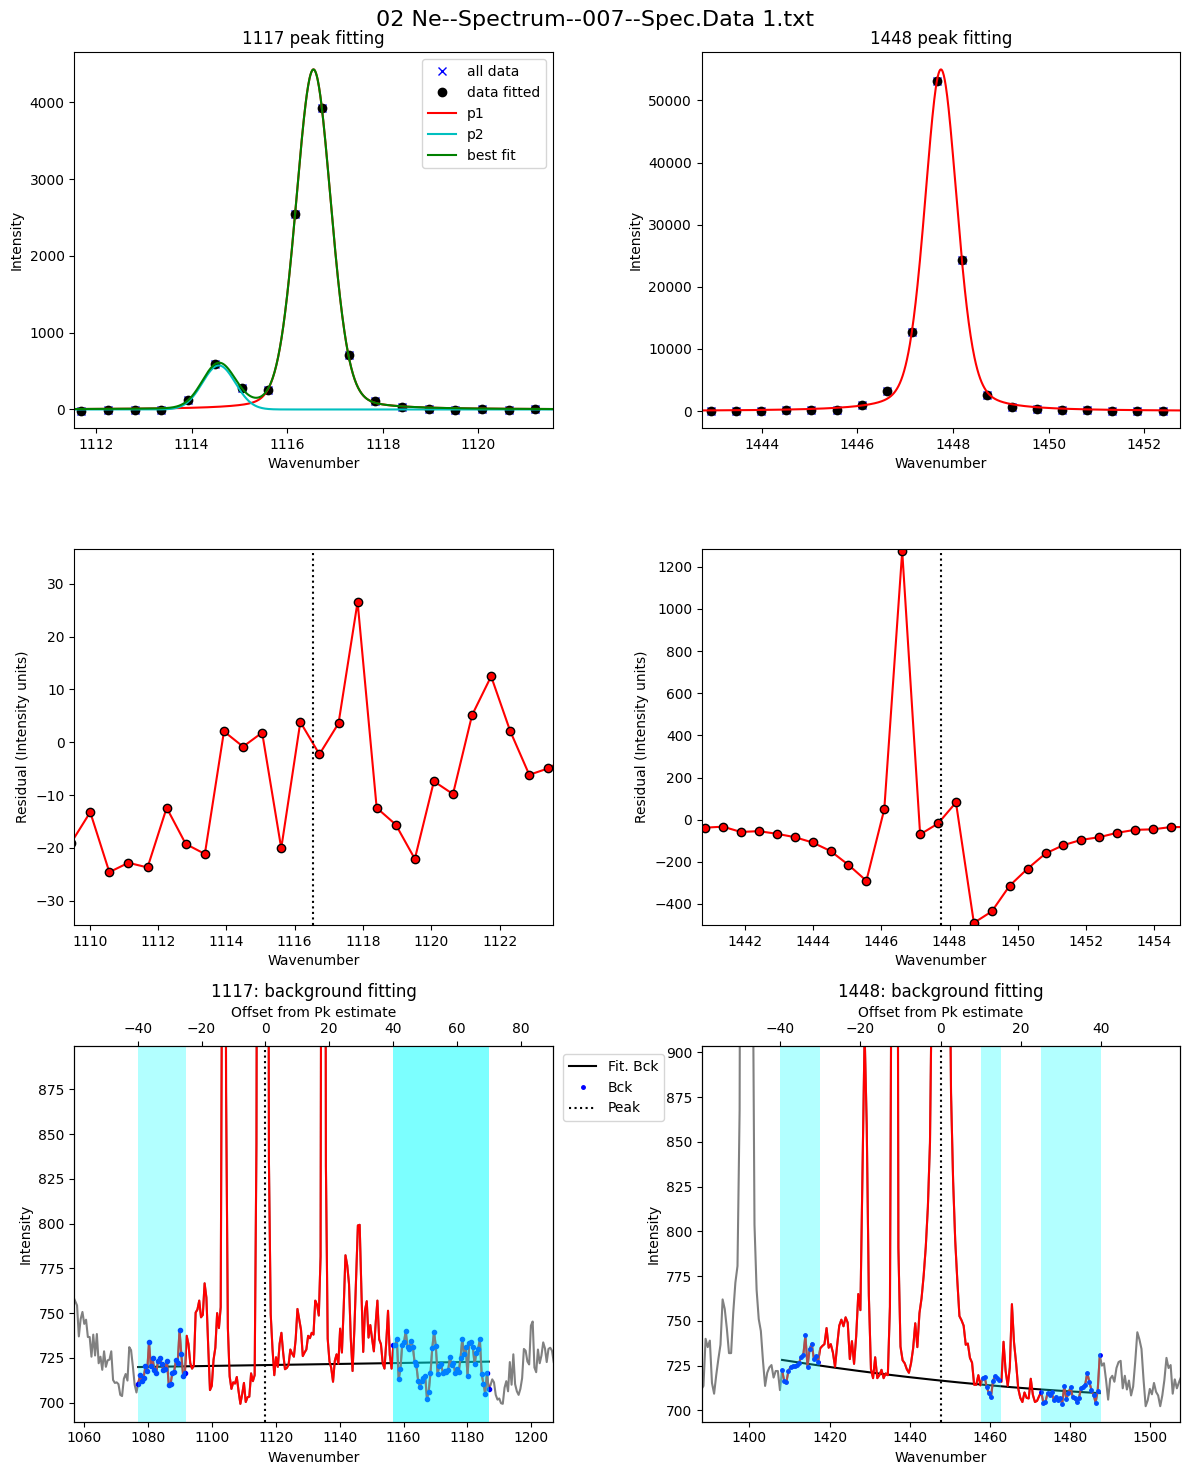

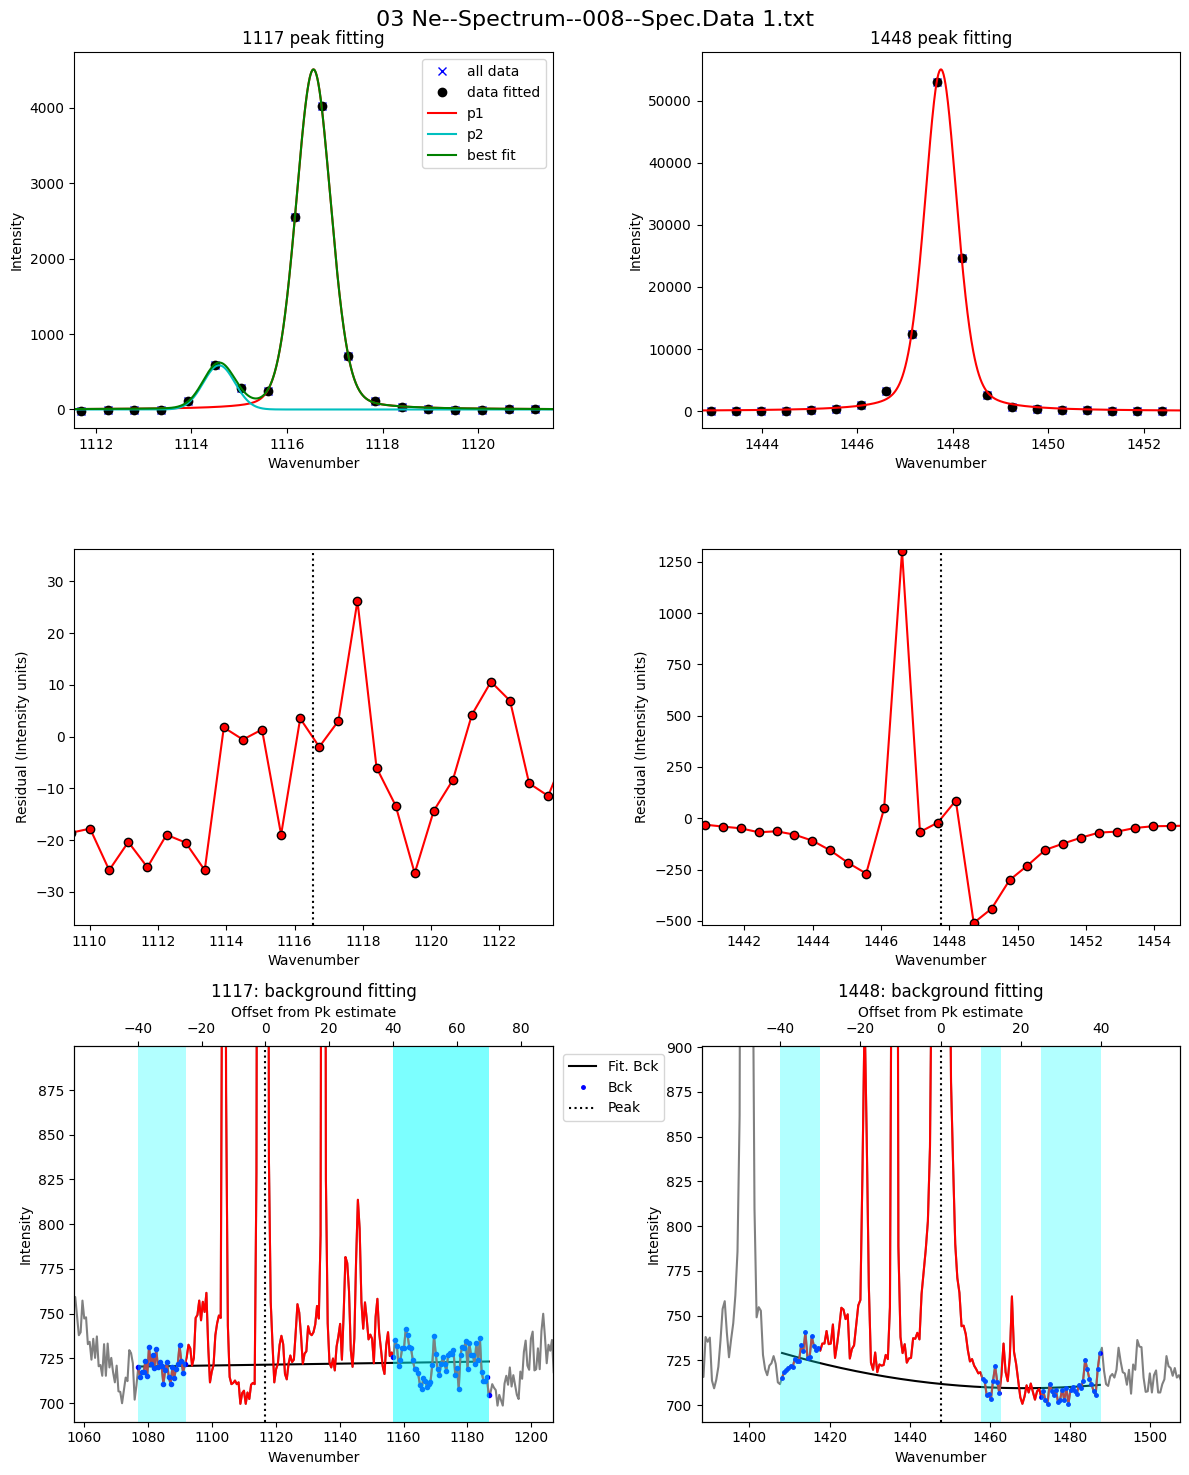

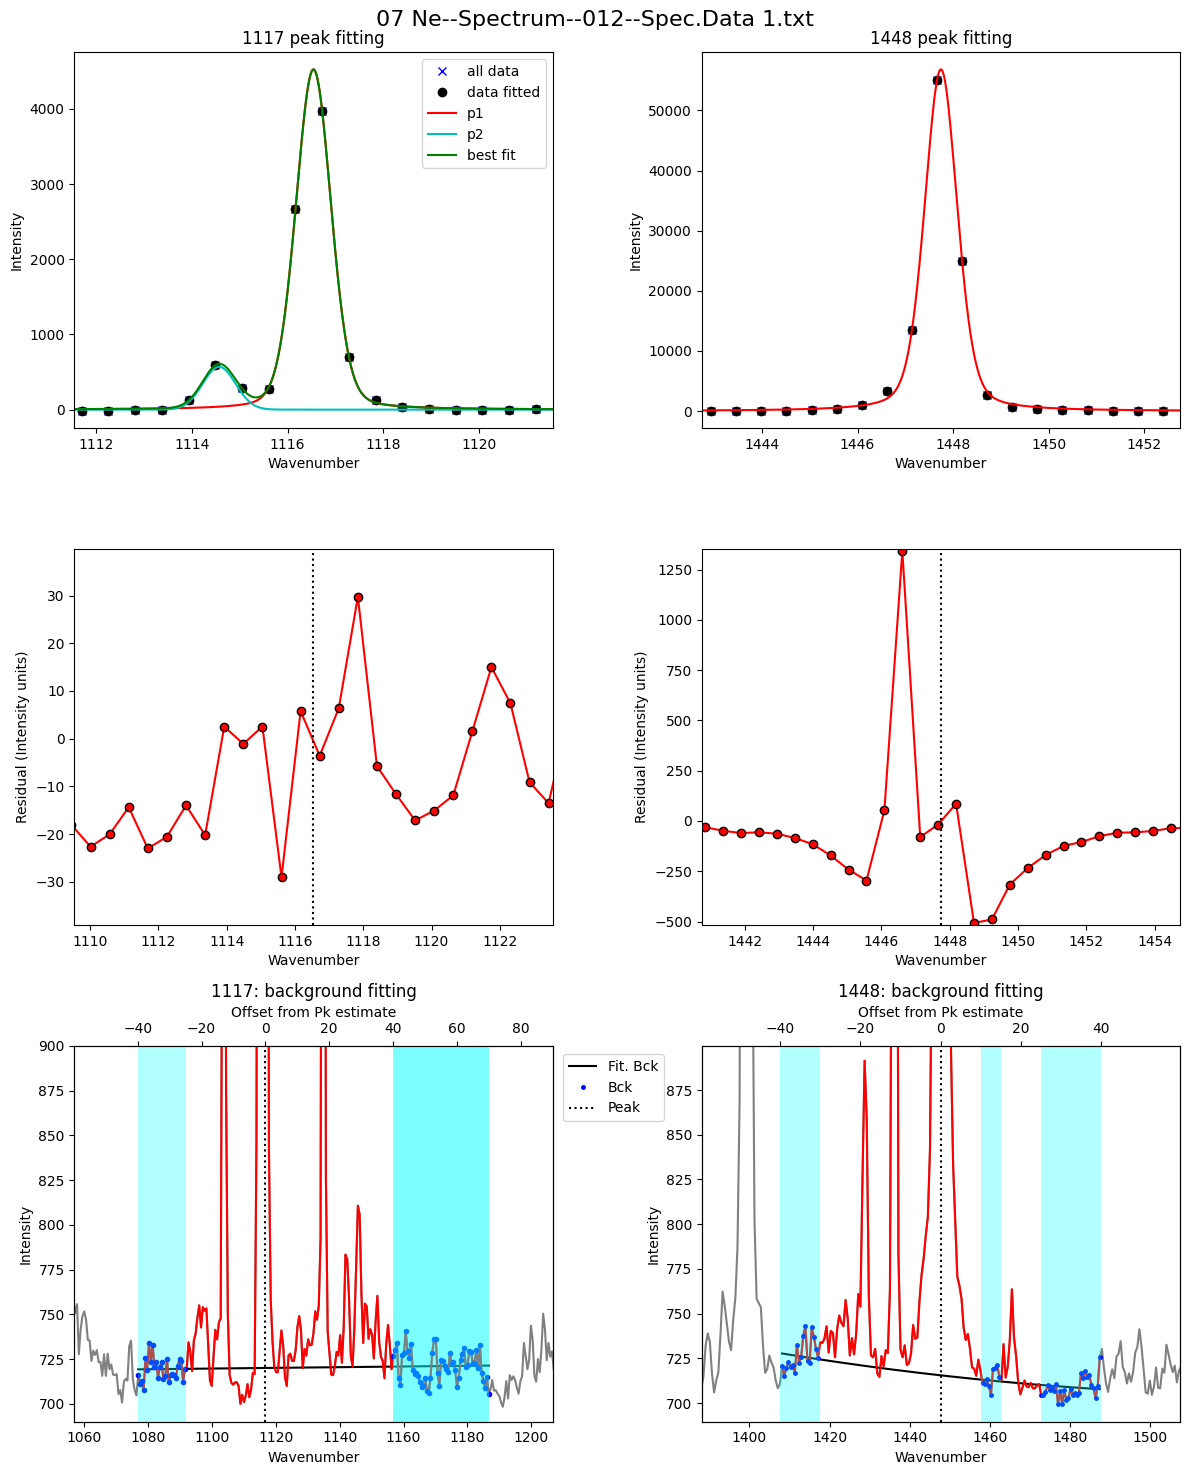

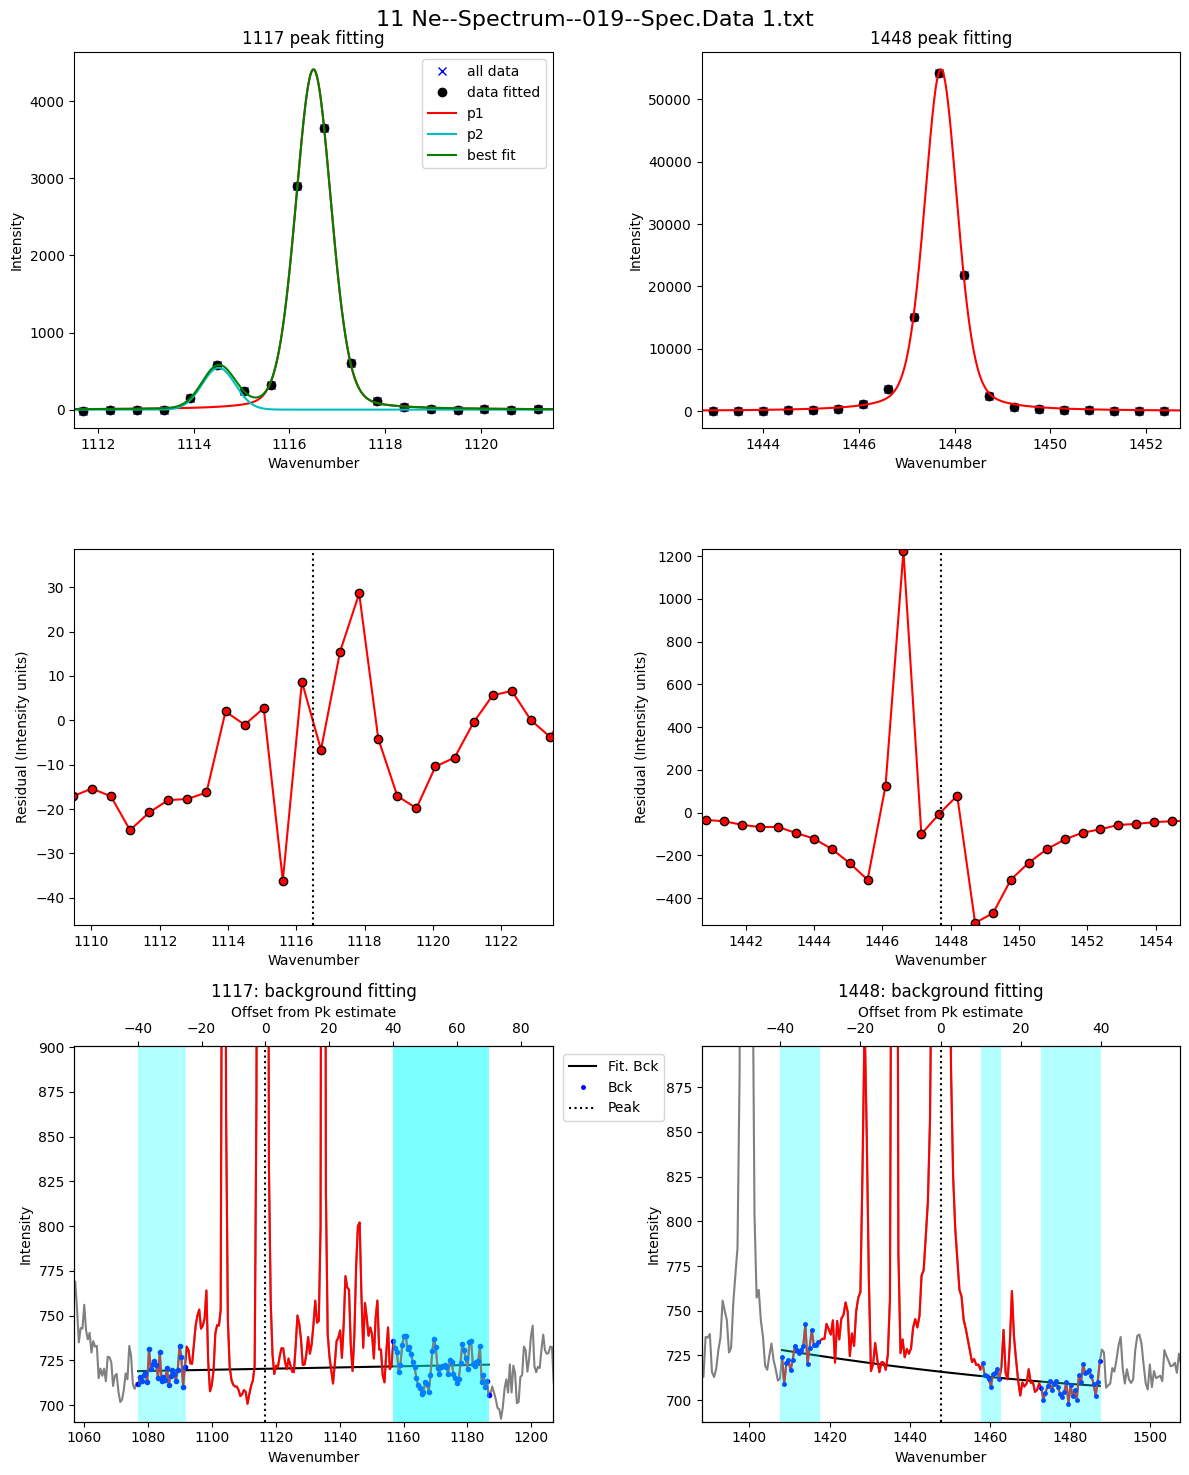

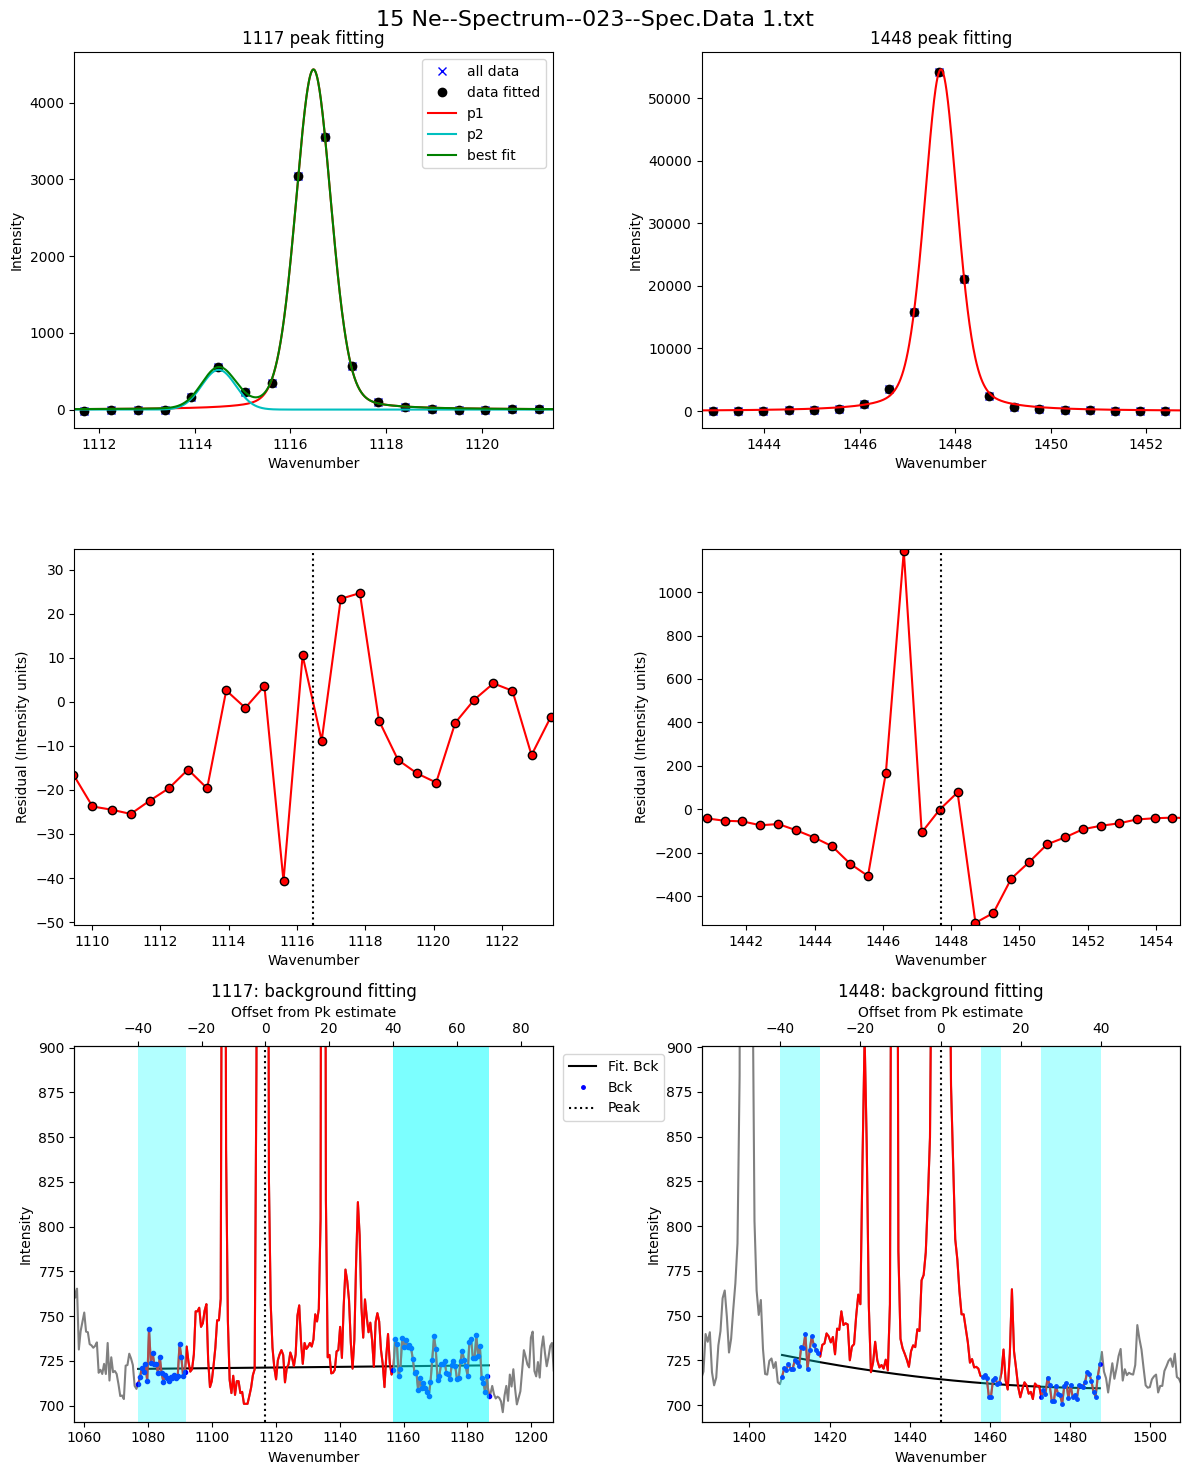

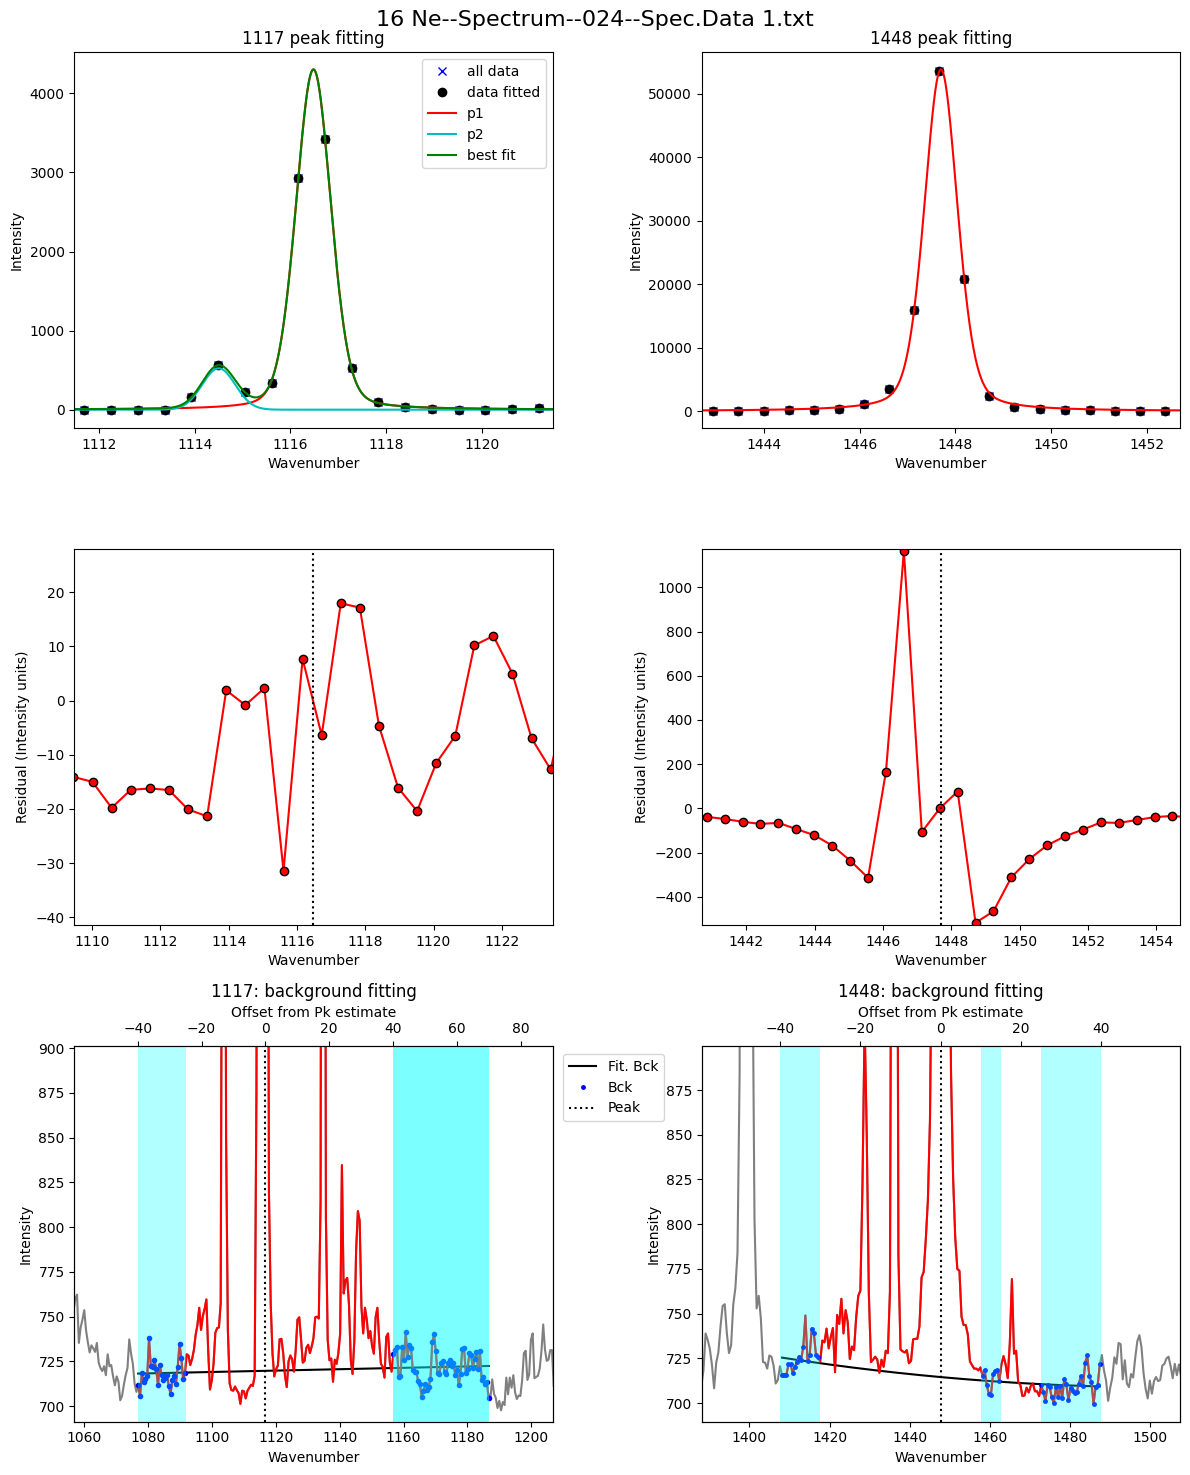

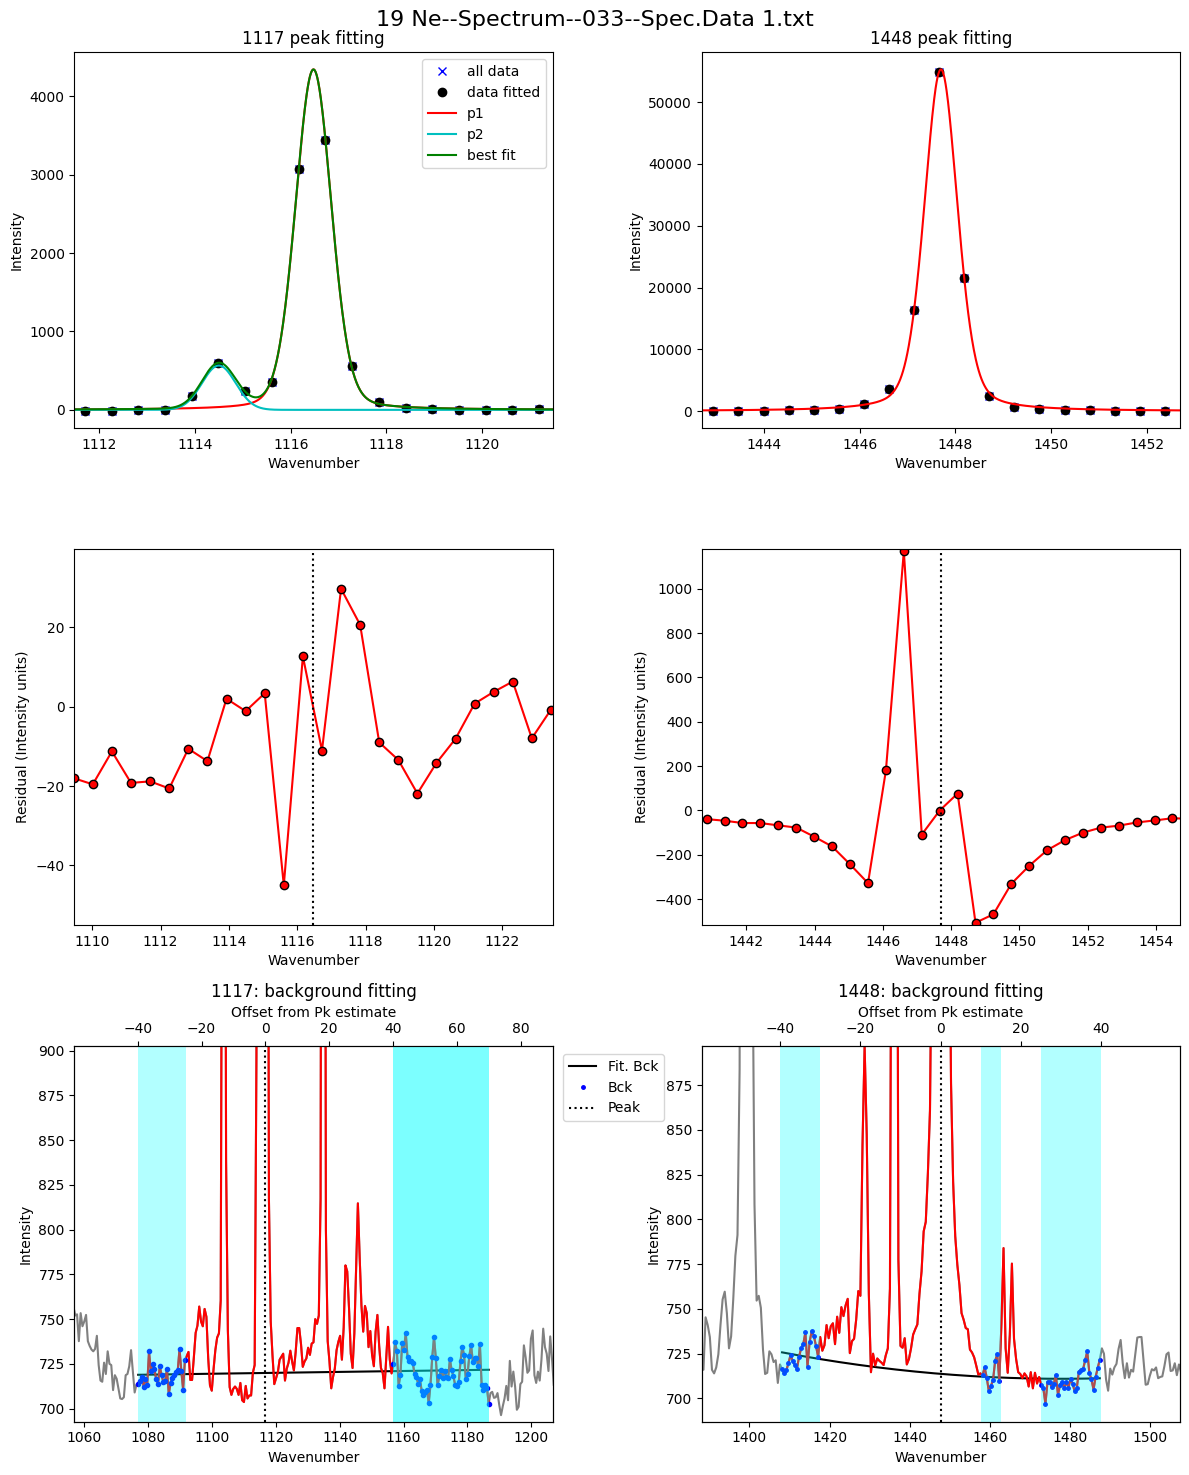

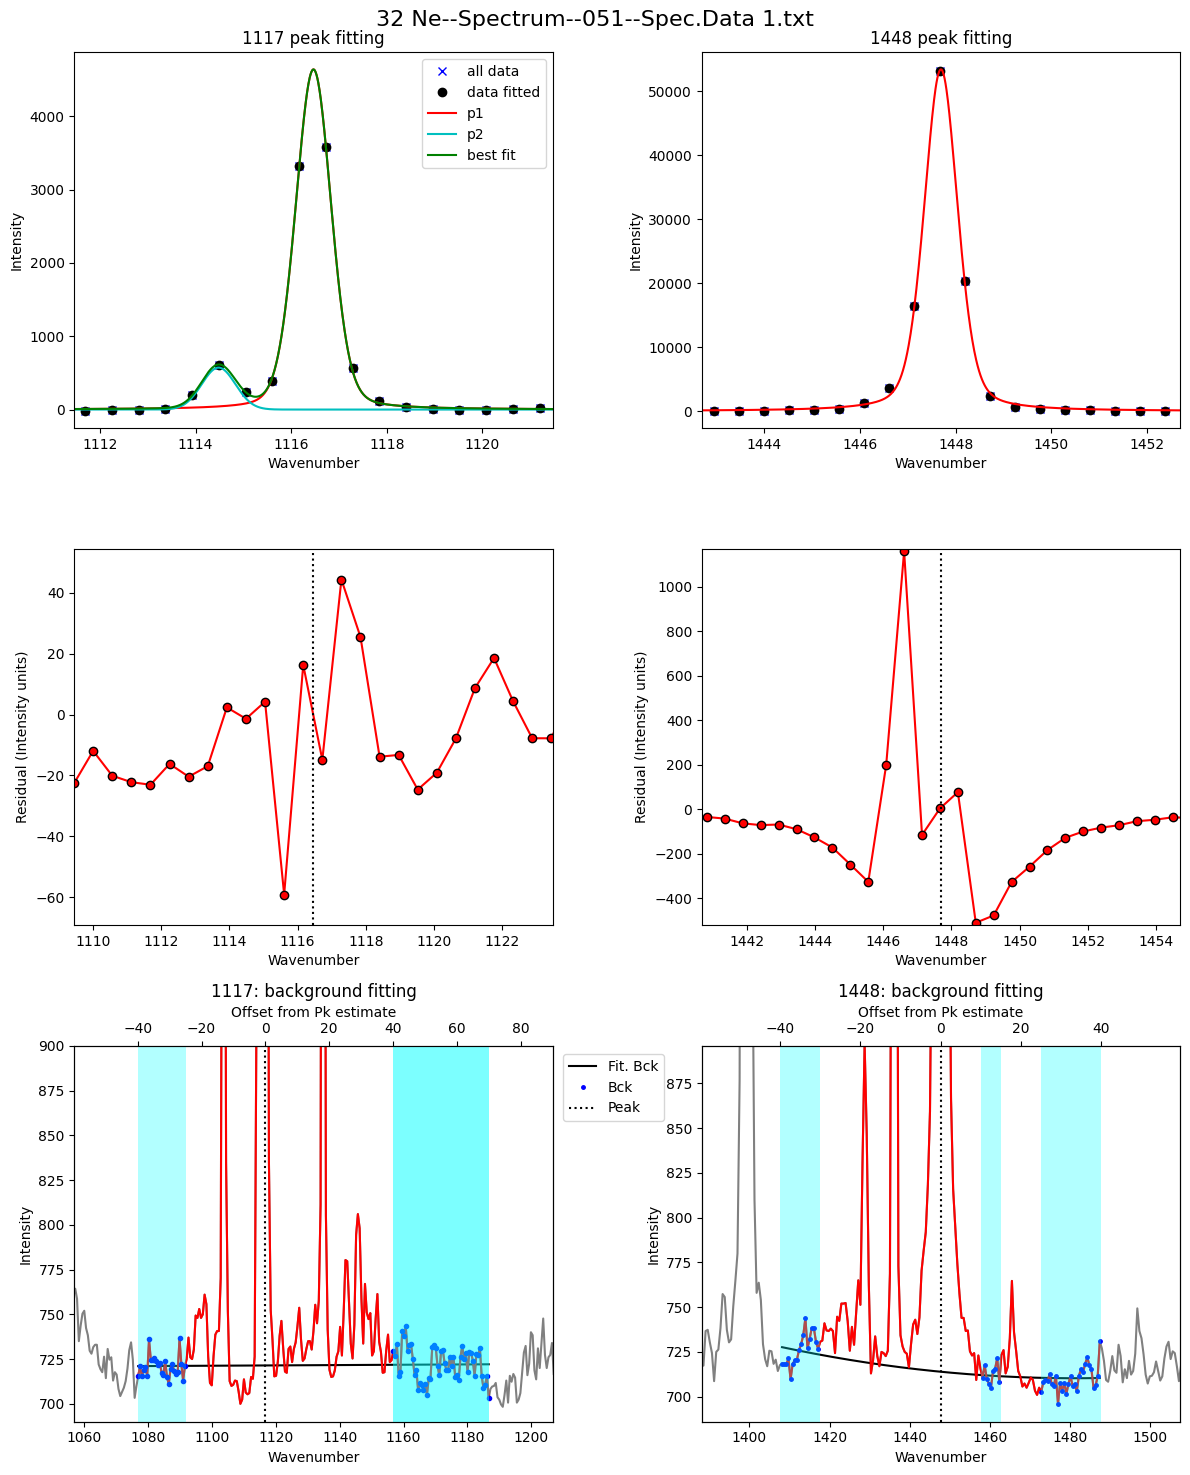

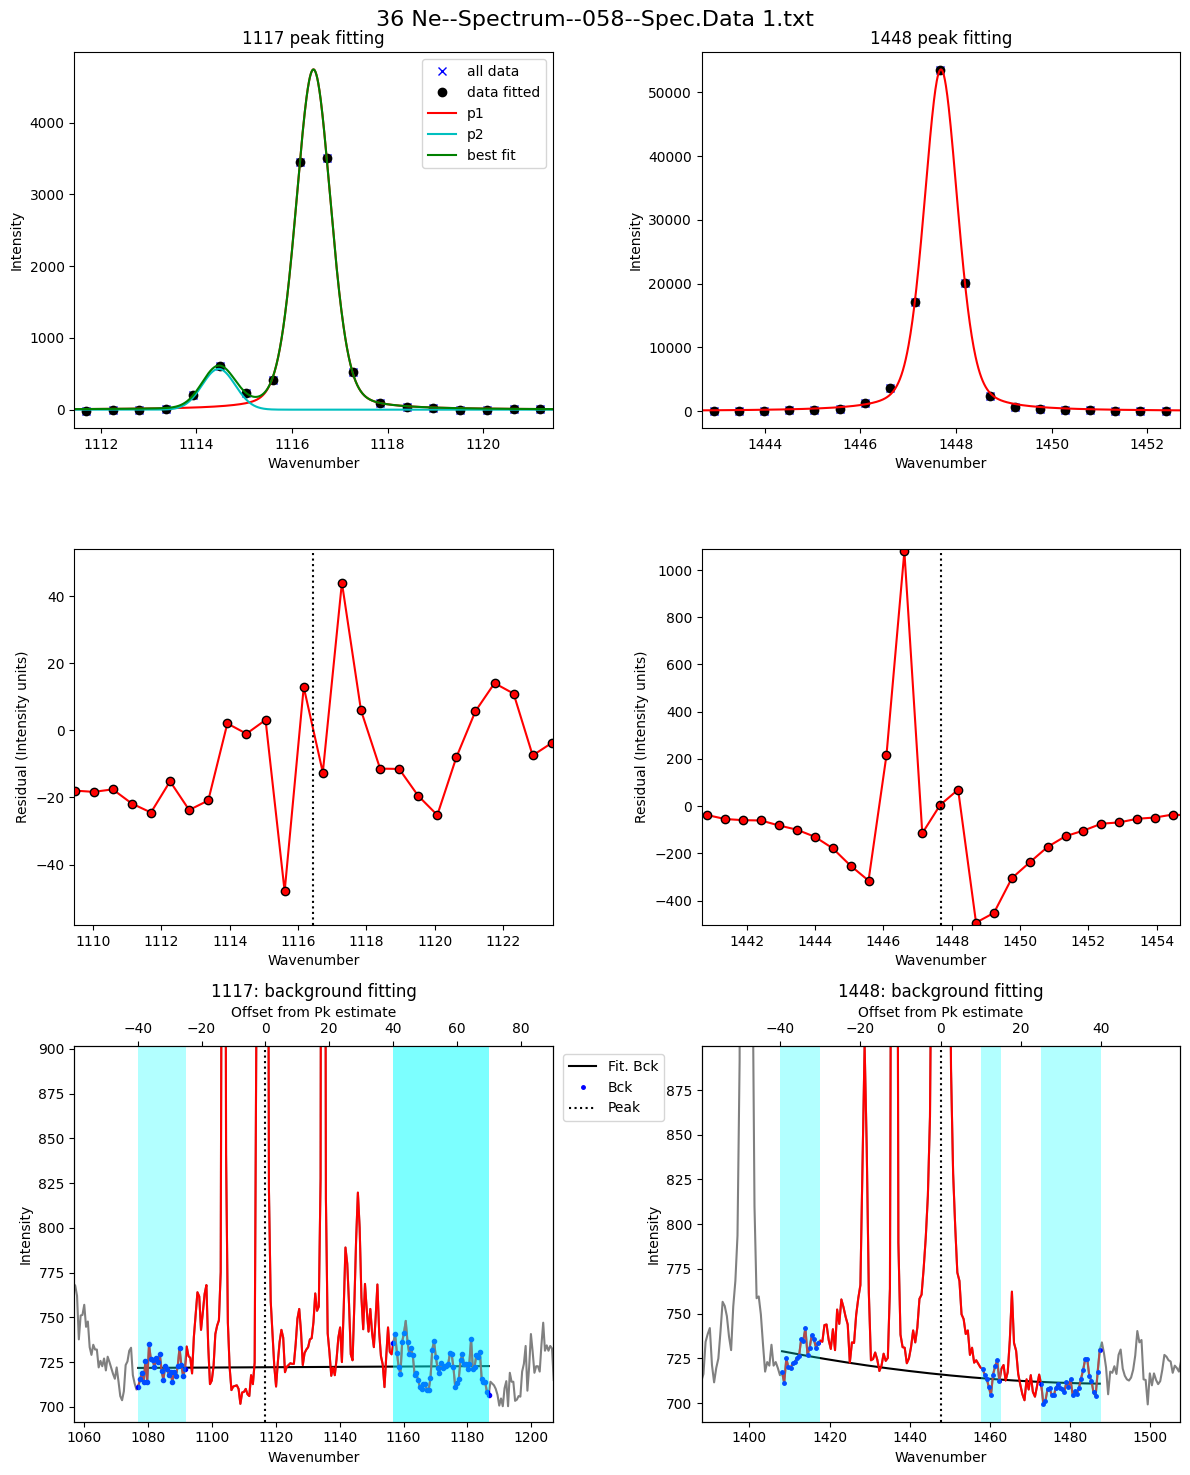

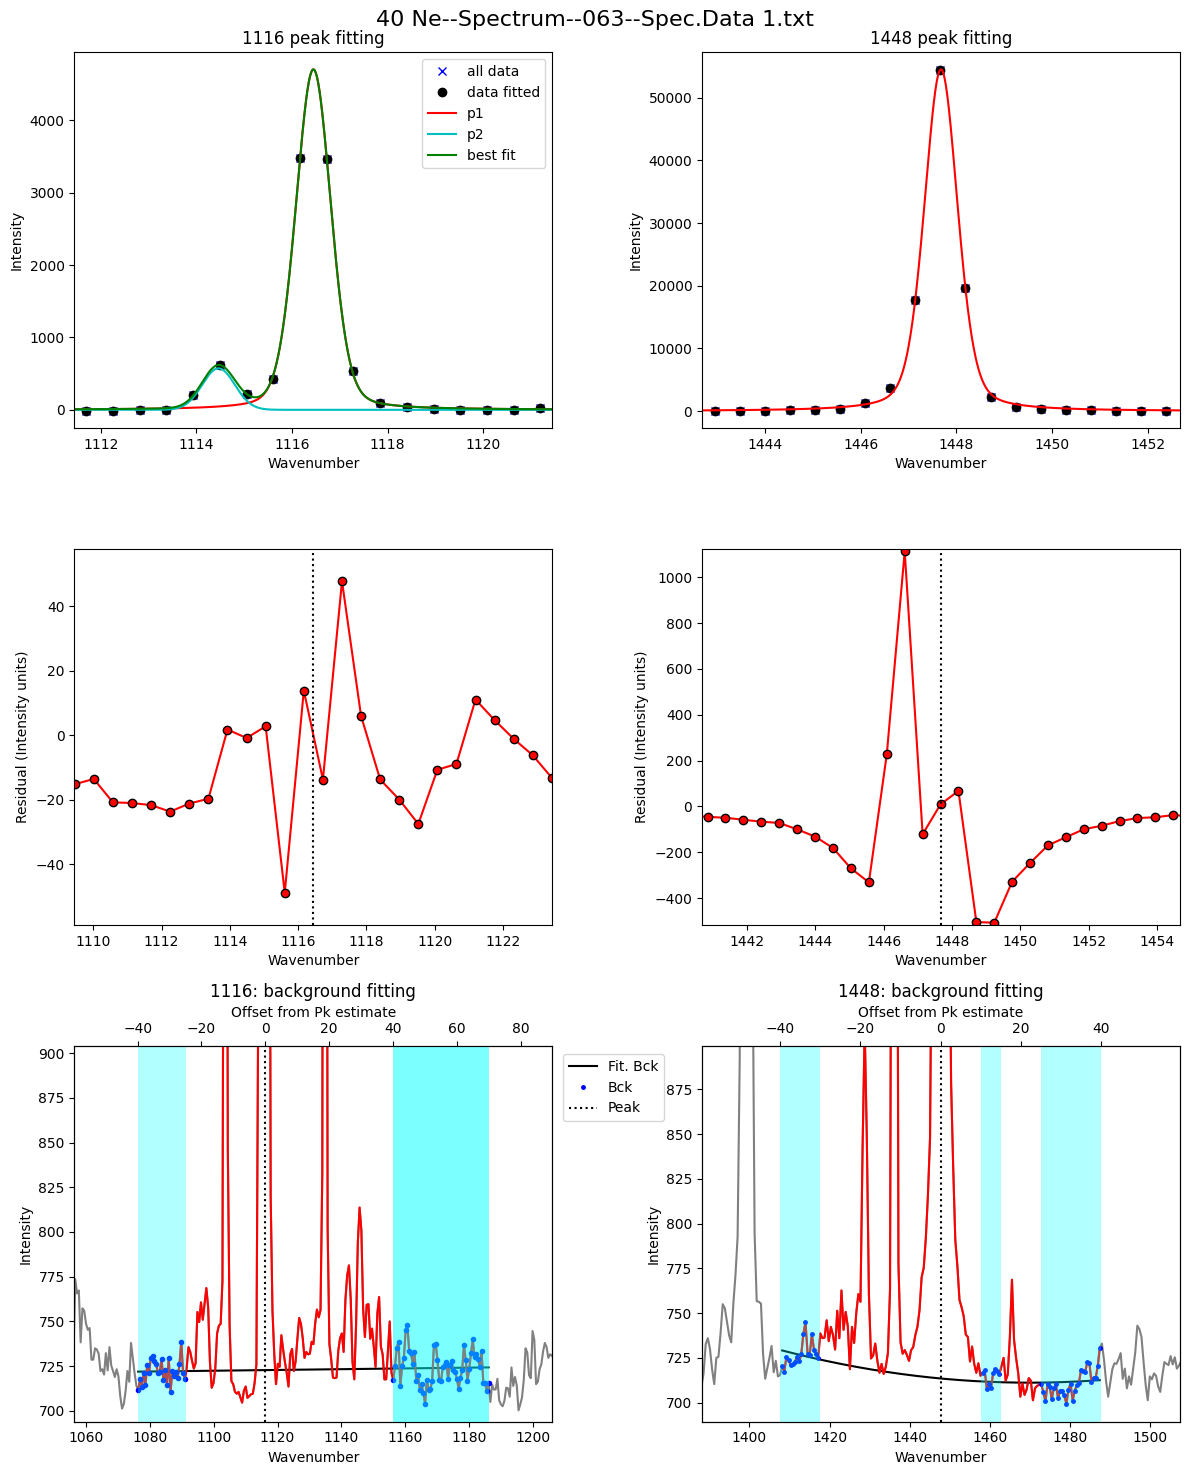

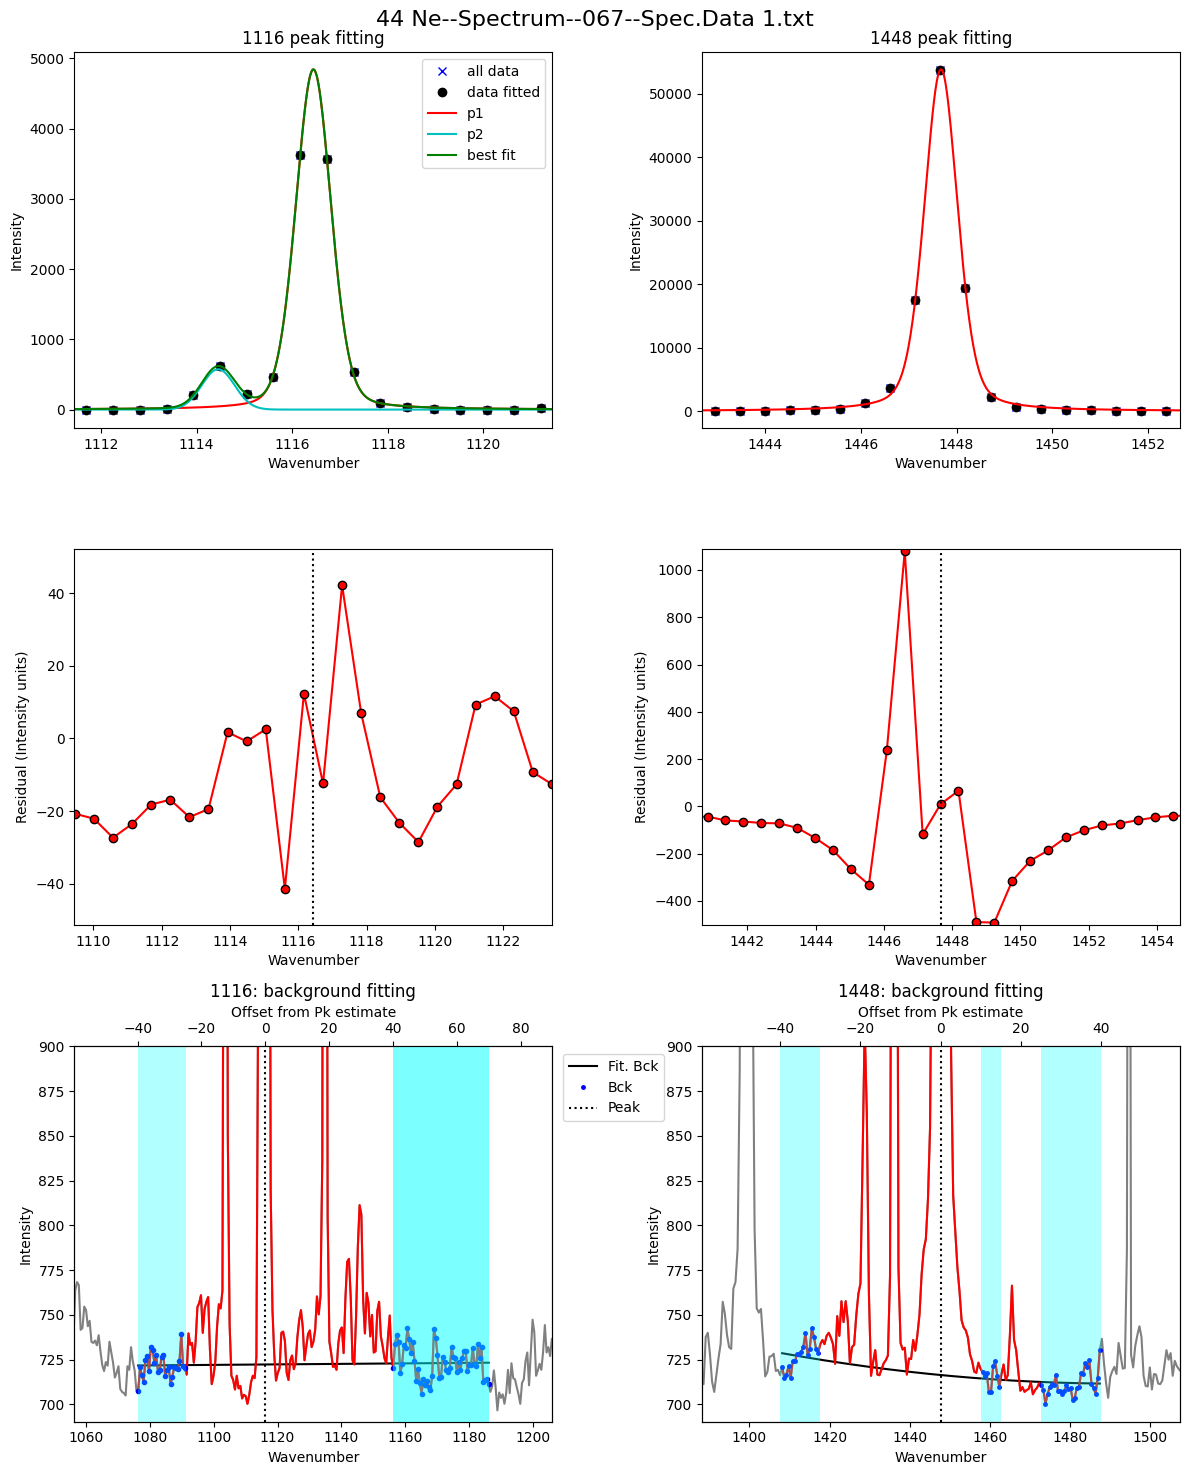

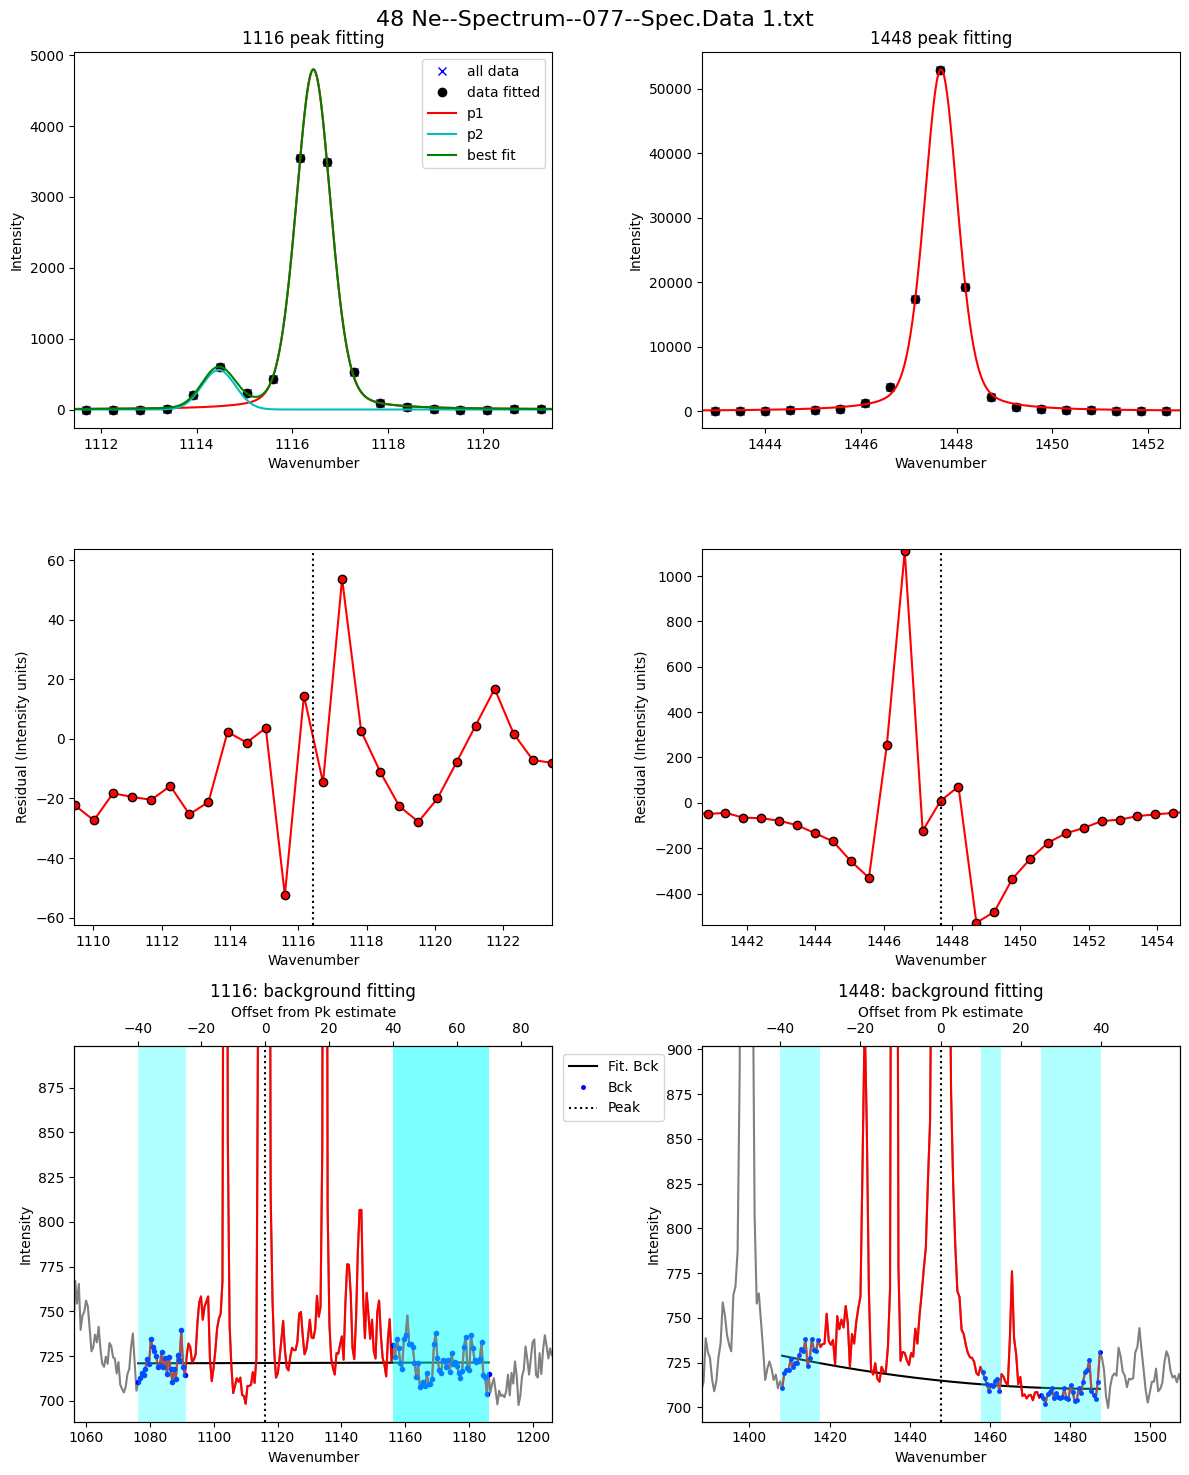

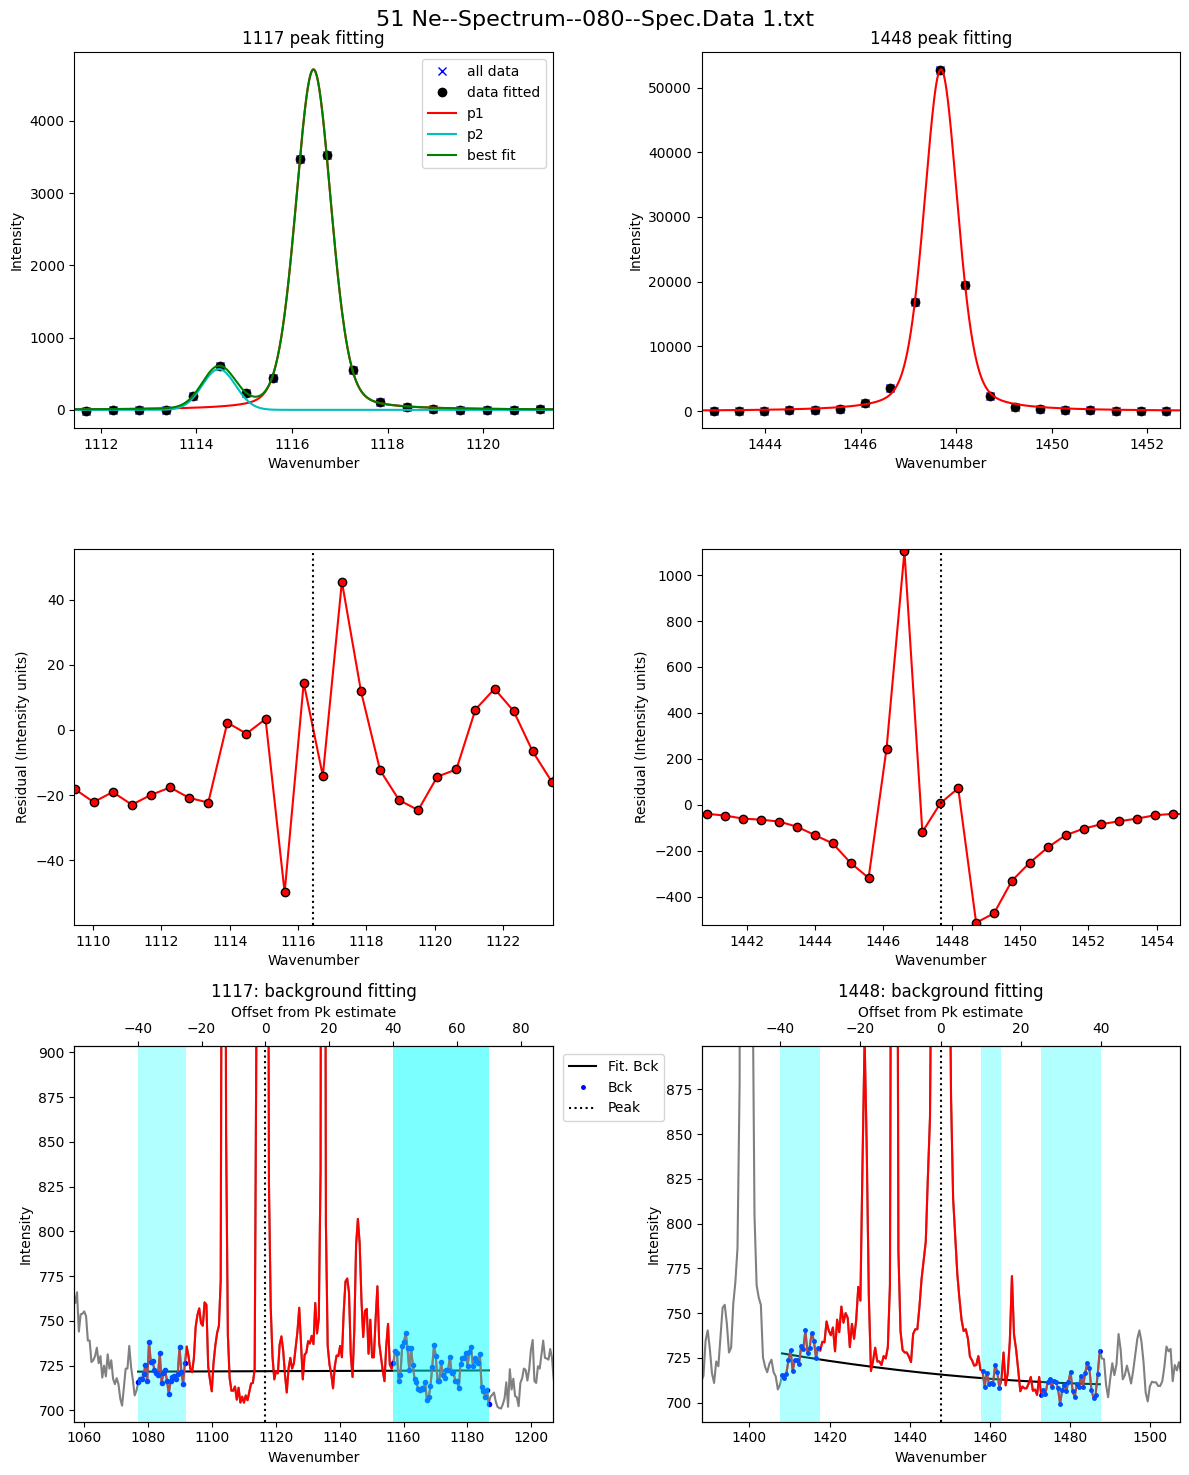

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0   Ne--Spectrum--006--Spec.Data 1.txt  0.997820    0.000033  331.199746   
1   Ne--Spectrum--007--Spec.Data 1.txt  0.997828    0.000037  331.197033   
2   Ne--Spectrum--008--Spec.Data 1.txt  0.997826    0.000037  331.197580   
3   Ne--Spectrum--012--Spec.Data 1.txt  0.997813    0.000037  331.201836   
4   Ne--Spectrum--019--Spec.Data 1.txt  0.997796    0.000034  331.207703   
5   Ne--Spectrum--023--Spec.Data 1.txt  0.997769    0.000032  331.216613   
6   Ne--Spectrum--024--Spec.Data 1.txt  0.997776    0.000033  331.214232   
7   Ne--Spectrum--033--Spec.Data 1.txt  0.997746    0.000031  331.224100   
8   Ne--Spectrum--051--Spec.Data 1.txt  0.997739    0.000027  331.226404   
9   Ne--Spectrum--058--Spec.Data 1.txt  0.997718    0.000027  331.233364   
10  Ne--Spectrum--063--Spec.Data 1.txt  0.997729    0.000028  331.229714   
11  Ne--Spectrum--067--Spec.Data 1.txt  0.997723    0.000027  331.231841   
12  Ne--Spectrum--077--Spec.Data 1.txt  0.997722    0.000026  331.232032   
13  Ne--Spectrum--080--Spec.Data 1.txt  0.997726    0.000027  331.230695   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.688593    1116.488846   51579.925069    4331.430627    131.109278   
1     1447.747691    1116.550658   53497.703985    4421.593129    129.718803   
2     1447.752407    1116.554826   53589.012877    4476.386446    128.207051   
3     1447.744368    1116.542532   55662.726408    4548.134434    136.414720   
4     1447.711769    1116.504066   54312.807432    4468.384198    135.452211   
5     1447.700989    1116.484376   54345.414198    4477.672810    136.762515   
6     1447.698377    1116.484144   53732.882801    4333.185634    134.651348   
7     1447.699802    1116.475701   55356.135715    4423.299412    136.846442   
8     1447.691857    1116.465453   53877.401034    4713.938560    139.804882   
9     1447.684478    1116.451114   54198.731888    4776.655329    134.696620   
10    1447.676283    1116.446569   54927.996978    4760.142941    140.040226   
11    1447.675168    1116.443327   54280.890348    4919.904224    139.659467   
12    1447.675325    1116.443293   53621.603699    4815.534663    141.844330   
13    1447.682056    1116.451361   53389.619350    4817.674640    139.227252   

    residual_pk1  ...  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0      13.854037  ...        0.402197   0.433187      None   0.010660   
1      12.022293  ...        0.380620   0.432647      None   0.012103   
2      12.655444  ...        0.384680   0.429919      None   0.011978   
3      12.674891  ...        0.384565   0.433134      None   0.012006   
4      11.958032  ...        0.390417   0.437271      None   0.011009   
5      13.190815  ...        0.394941   0.436733      None   0.010266   
6      12.414117  ...        0.392163   0.431609      None   0.010813   
7      12.447529  ...        0.390499   0.441976      None   0.010064   
8      16.382402  ...        0.401655   0.435893      None   0.008852   
9      14.809256  ...        0.396367   0.427920      None   0.008868   
10     15.567446  ...        0.399586   0.431186      None   0.009046   
11     16.185422  ...        0.403367   0.434762      None   0.008858   
12     16.044924  ...        0.404839   0.427263      None   0.008474   
13     15.813807  ...        0.403255   0.435643      None   0.008856   

    Peak1_Prop_Lor  Ne_Corr_min Ne_Corr_max  residual_pk1+pk2  \
0         0.243285     0.997781    0.997858        144.963316   
1         0.241392     0.997785    0.997870        141.741096   
2         0.241140     0.997784    0.997868        140.862494   
3         0.255637     0.997771    0.997855        149.089611   
4         0.250788     0.997757    0.997835        147.410243   
5         0.246074     0.997732    0.997806        149.953330   
6         0.271059     0.997738    0.997814        147.065465   
7         0.236649     0.997711    0.997782        149.293971   
8      

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['07 Ne--Spectrum--006--Information.txt',
 '08 Ne--Spectrum--007--Information.txt',
 '09 Ne--Spectrum--008--Information.txt',
 '13 Ne--Spectrum--012--Information.txt',
 '19 Ne--Spectrum--019--Information.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 14/14 [00:00<00:00, 134.38it/s]

Done


filename                date    Month   Day  \
0  Ne--Spectrum--006--Information.txt  January 16, 2024\n  January  16.0   
1  Ne--Spectrum--007--Information.txt  January 16, 2024\n  January  16.0   
2  Ne--Spectrum--008--Information.txt  January 16, 2024\n  January  16.0   
3  Ne--Spectrum--012--Information.txt  January 16, 2024\n  January  16.0   
4  Ne--Spectrum--019--Information.txt  January 16, 2024\n  January  16.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0      14.901          45.0            3.0    100.0  ['0h', '2m', '16s']   
1      14.924          45.0            3.0    100.0  ['0h', '2m', '16s']   
2      14.937          45.0            3.0    100.0  ['0h', '2m', '16s']   
3       6.079          45.0            3.0    100.0  ['0h', '2m', '17s']   
4       6.110          45.0            3.0    100.0  ['0h', '2m', '17s']   

       24hr_time  sec since midnight  Spectral Center  
0  12:46:27 PM\n             45987.0         1325.004  
1  12:50:14 PM\n             46214.0         1325.004  
2  12:52:37 PM\n             46357.0         1325.004  
3   1:16:41 PM\n             47801.0         1325.004  
4   2:04:35 PM\n             50675.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)

for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m

good job, no duplicate file names


array(['Ne--Spectrum--006', 'Ne--Spectrum--007', 'Ne--Spectrum--008',
       'Ne--Spectrum--012', 'Ne--Spectrum--019', 'Ne--Spectrum--023',
       'Ne--Spectrum--024', 'Ne--Spectrum--033', 'Ne--Spectrum--051',
       'Ne--Spectrum--058', 'Ne--Spectrum--063', 'Ne--Spectrum--067',
       'Ne--Spectrum--077', 'Ne--Spectrum--080'], dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)

for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

good job, no duplicate file names


array(['Ne--Spectrum--006', 'Ne--Spectrum--007', 'Ne--Spectrum--008',
       'Ne--Spectrum--012', 'Ne--Spectrum--019', 'Ne--Spectrum--023',
       'Ne--Spectrum--024', 'Ne--Spectrum--033', 'Ne--Spectrum--051',
       'Ne--Spectrum--058', 'Ne--Spectrum--063', 'Ne--Spectrum--067',
       'Ne--Spectrum--077', 'Ne--Spectrum--080'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 14, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [21]:
0.4/df_combo['error_pk2']

0     196.688550
1     198.462329
2     199.010937
3     206.659981
4     206.982207
5     208.568843
6     207.616492
7     219.063342
8     206.725480
9     211.012350
10    210.308720
11    215.025406
12    201.780833
13    204.199494
Name: error_pk2, dtype: float64

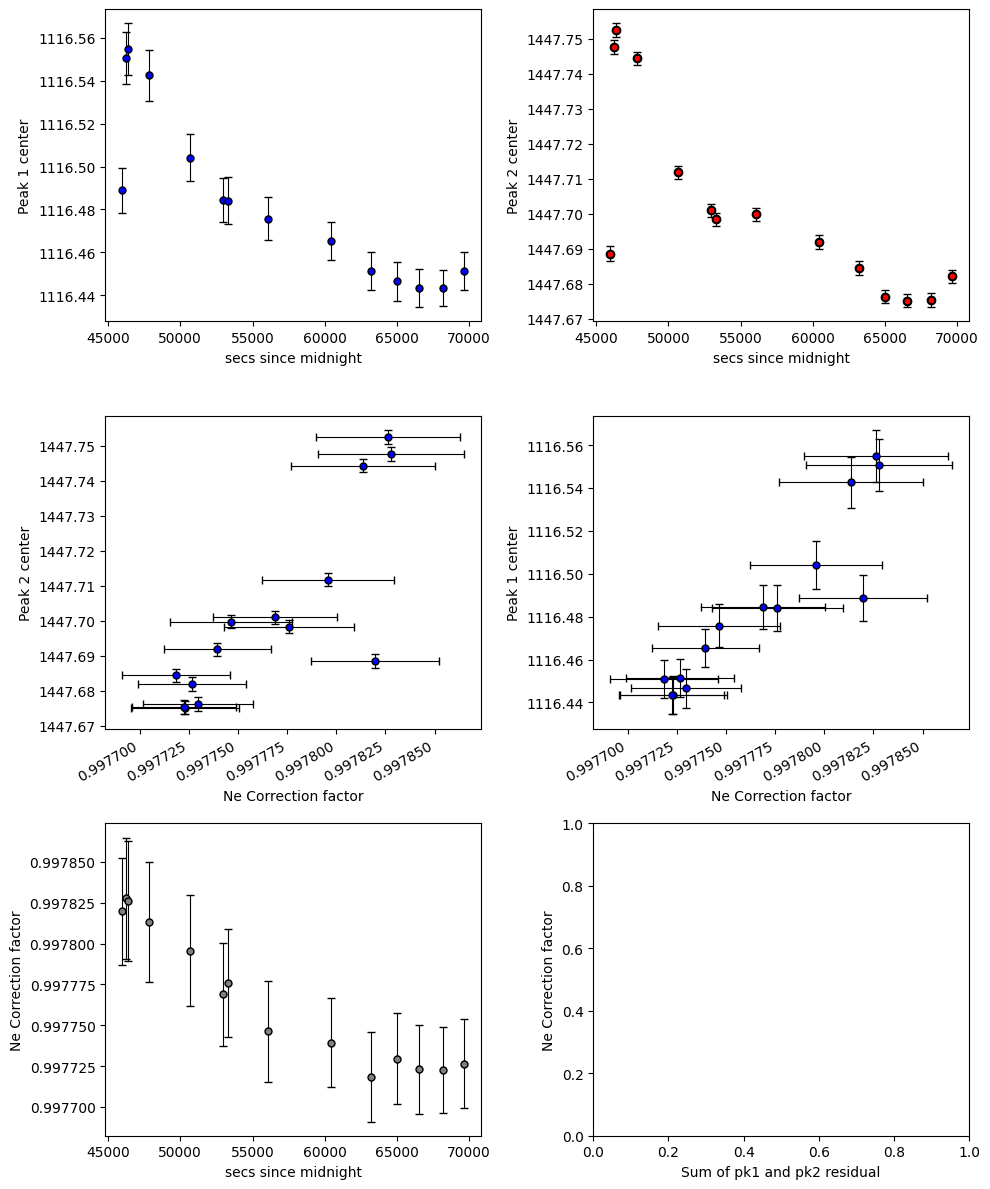

In [22]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [23]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

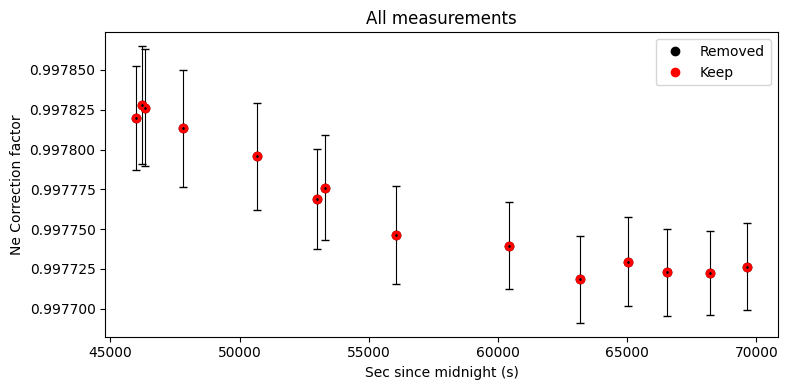

In [24]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

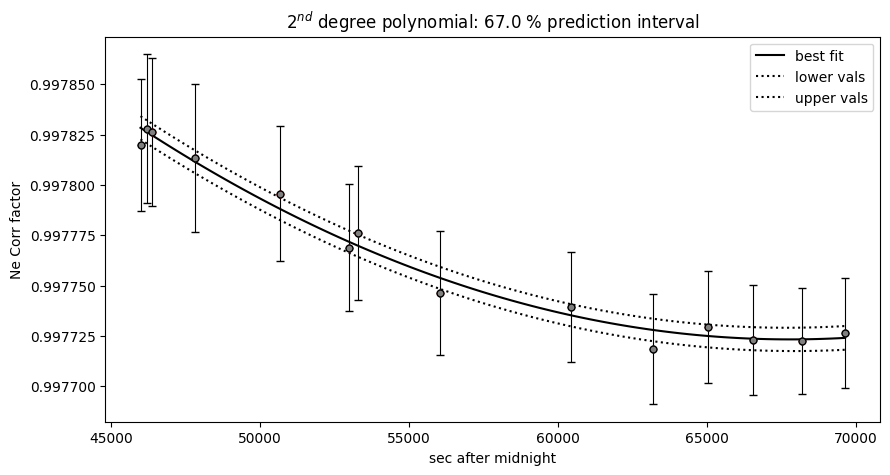

In [25]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model.pkl')
